In [1]:
import matplotlib.pyplot as plt
from utils import (
    PerlinNoiseConfig,
    generate_heightmap,
    TerrainConfig,
    PyForestConfig,
    generate_forest_adapted_to_terrain,
)
import numpy as np

In [19]:
width = height = 505

In [20]:
config = PerlinNoiseConfig(
    height=width,
    width=height,
    scale=150.0,
    octaves=4,
    persistence=0.5,
    lacunarity=2.0,
)

mountains = [
    (45, 50, 25.0, 1.0),  # (y, x, sigma, amplitude)
    # (100, 200, 40, 0.9),
    # (220, 100, 30, 1.2),
    # (150, 60, 10, 2),
]

heightmap = generate_heightmap(
    config=config, mountains=mountains, terrain_amplifier=1
)

In [ ]:
from PIL import Image

h_16 = np.round(heightmap * 65535.0).astype(np.uint16)
img = Image.fromarray(h_16, mode="I;16")
img.save("h_16.png", format="PNG")

In [ ]:
# from matplotlib.image import imsave

# h = (heightmap * 255).astype(np.int16)

# imsave("heightmap.png", h, cmap="gray")

In [15]:
from PIL import Image

img = Image.open("heightmap.png")

img = img.convert("L")

img.save("heightmap_g.png")

In [5]:
forest_map = generate_forest_adapted_to_terrain(
    config=PyForestConfig(
        width=width,
        height=height,
        initial_trees=5,
        seed_radius=15,
        seed_strength=0.05,
        seed_decay_rate=0.2,
        n_iterations=3,
        space_between_trees=5,
    ),
    heightmap=heightmap,
)

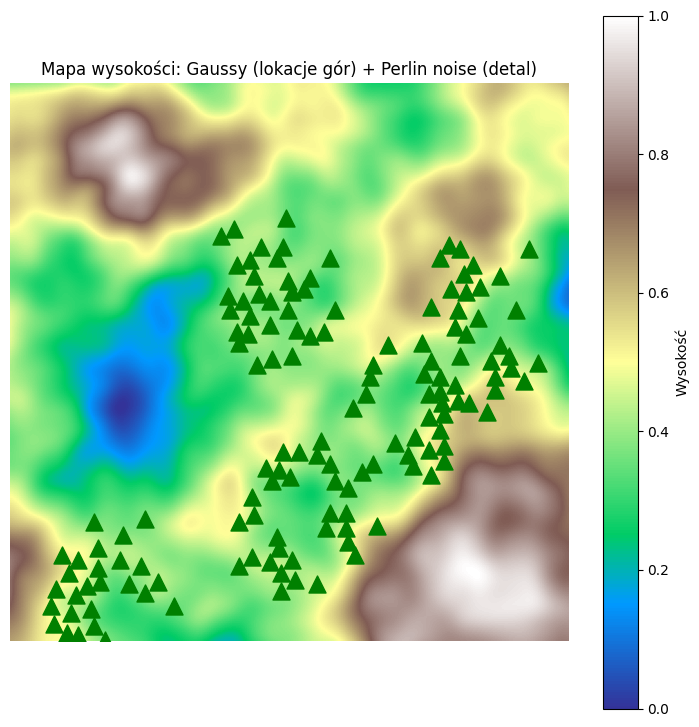

In [6]:
trees = forest_map == 2
unplantable = forest_map == -1

y_trees, x_trees = np.where(trees)
y_unplantable, x_unplantable = np.where(unplantable)

plt.figure(figsize=(9, 9))
plt.imshow(heightmap, cmap="terrain")
plt.colorbar(label="Wysokość")
plt.scatter(x_unplantable, y_unplantable, color="red", marker="x")
plt.scatter(x_trees, y_trees, color="green", marker="^", s=150)
plt.title("Mapa wysokości: Gaussy (lokacje gór) + Perlin noise (detal)")
plt.axis("off")
plt.show()

In [7]:
config = TerrainConfig(
    XSize=width,
    YSize=height,
    Scale=100.0,
    ZMultiplier=7000.0,
    UVScale=1.0,
    Heightmap=heightmap.reshape(-1).tolist(),
    VegetationMap=forest_map.reshape(-1).tolist(),
)

In [8]:
config.export_to_json()

In [9]:
from enum import Enum
from numpy.typing import NDArray
import matplotlib.pyplot as plt


class VegetationType(Enum):
    EMPTY = 0
    SEED = 1
    TREE = 3


class Tree:
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y


class Seed:
    def __init__(self, x: int, y: int, strength: float):
        self.x = x
        self.y = y
        self.strength = strength


class Forest:
    def __init__(
        self,
        width: int,
        height: int,
        initial_trees: int = 5,
        seed_radius: int = 5,
        seed_strength: float = 0.05,
        seed_decay_rate: float = 0.2,
        desired_coverage: float = 0.15,
    ) -> None:
        self.width = width
        self.height = height
        self.initial_trees = initial_trees
        self.seed_radius = seed_radius
        self.seed_strength = seed_strength
        self.seed_decay_rate = seed_decay_rate
        self.desired_coverage = desired_coverage

        self._forest_map: NDArray = np.zeros((width, height))
        self._trees: list[Tree] = []
        self._seeds: list[Seed] = []

        self._init_trees()
        while self._get_coverage() < self.desired_coverage:
            self._seed_trees()
            self._grow_trees()
            self._decay_seeds()

        self._forest_map[self._forest_map == VegetationType.SEED.value] = (
            VegetationType.EMPTY.value
        )

    def _init_trees(self) -> None:
        for _ in range(self.initial_trees):
            x_rand = np.random.randint(0, self.width)
            y_rand = np.random.randint(0, self.height)

            self._forest_map[y_rand, x_rand] = VegetationType.TREE.value
            self._trees.append(Tree(x=x_rand, y=y_rand))

    def _seed_trees(self) -> None:
        for tree in self._trees:
            for x in range(tree.x - self.seed_radius, tree.x + self.seed_radius + 1):
                if x < 0 or x >= self.width:
                    continue

                for y in range(
                    tree.y - self.seed_radius, tree.y + self.seed_radius + 1
                ):
                    if y < 0 or y >= self.height:
                        continue

                    if (
                        (x - tree.x) ** 2 + (y - tree.y) ** 2 <= self.seed_radius**2
                        and self._forest_map[y, x] != VegetationType.TREE.value
                        and x % 2 == 0
                        and y % 2 == 0
                    ):
                        new_seed = Seed(x, y, self.seed_strength)

                        # if new_seed is already in self._seeds return its index, else return None
                        index = next(
                            (
                                i
                                for i, seed in enumerate(self._seeds)
                                if seed.x == new_seed.x and seed.y == new_seed.y
                            ),
                            None,
                        )
                        if not index:
                            self._seeds.append(new_seed)
                            self._forest_map[y, x] = VegetationType.SEED.value
                        # if index:
                        #     self._seeds[index].strength += new_seed.strength
                        # else:
                        #     self._seeds.append(new_seed)
                        #     self._forest_map[y, x] = VegetationType.SEED.value

    def _grow_trees(self) -> None:
        # I am deleting elements whilst looping through list, so
        # to make sure no elements will be skipped I loop from the end
        for i in reversed(range(len(self._seeds))):
            seed = self._seeds[i]
            if np.random.rand() < seed.strength:
                self._trees.append(Tree(seed.x, seed.y))
                self._forest_map[seed.y, seed.x] = VegetationType.TREE.value
                self._seeds.pop(i)

    def _decay_seeds(self) -> None:
        self._seeds = [seed for seed in self._seeds if seed.strength > 0]

    def _get_coverage(self) -> float:
        return len(self._trees) / (self._forest_map.size / 2)

    def display_forest(self) -> None:
        trees = self._forest_map == VegetationType.TREE.value
        seeds = self._forest_map == VegetationType.SEED.value

        y_trees, x_trees = np.where(trees)
        y_seeds, x_seeds = np.where(seeds)

        plt.figure(figsize=(5, 5))
        plt.scatter(x_seeds, y_seeds, marker=".", color="brown")
        plt.scatter(x_trees, y_trees, marker="^", color="green")
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.axis("off")

        plt.show()